<a href="https://colab.research.google.com/github/PedroBritodSa/Physics-Informed-Neural-Network-Project/blob/main/Best_Q_balls_eq_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q-balls solutions using Deep Learning**


- In this notebook, we will create a Physics-Informed Neural Network to solve the Klein gordon solution and obtain the results of Q-balls. The Klein Gordon equation is then given by:

$\left(\partial_{\mu}\partial^{\mu} + \frac{\partial U}{\partial |\Phi|^{2}}\right)\Phi=0$

-To do so, we choose to work with the case of a spherically symetric Q-ball, which the line element is given by the equation:

$ds^{2}=−dt^{2} + dr^{2} + r^{2}dθ^{2} + r^{2}sinθ^{2} dφ$

- To guarantee the formation of soliton solutions, we choose the following Ansatz for the scalar field

$\Phi = \phi(r)e^{-i \omega t}$

- Replacing the Ansatz for the metric and the scalar field in the Klein-Gordon equation, we obtain:

$\frac{ d^{2} \phi(r)}{dr^{2}} + \frac{2}{r}\frac{ d \phi(r)}{dr}=\left( \frac{dU}{d|\Phi|^{2}}-\omega^{2}\right)\phi(r)$
- We choose to work with the simplest potential that would allow the existence of these solutions

$U(|Φ|) = m^{2} |Φ|^{2} − β|Φ|^{4} + λ|Φ|^{6} $.

- So the derivative of U is given by:

$\frac{dU}{d|\Phi|^{2}} = m^{2} − 4*β|Φ|^{2} + 6*λ|Φ|^{4} $
- Let's move on to the implementation

## The eingenvalue problem

- The set of equations above is known as an eigenvalue system of equations. In order to solve it, we first need to determine the value of the eingenvalue $\omega$.
- This task is usually solve by the implementation of an algorithm which finds the best omega that satisfy the solution.
- We can implement such algorithm, or create a PINN to solve this step too.  
- By the method of backward propagation, the PINN can adjust the values of the omega that better fit the solution

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython import display
import imageio
import os
from scipy.interpolate import CubicSpline


#Gradients
def gradients(outputs, inputs, order=1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs


### Exact solution for comparison

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp


def event1(r,y,w):

  return y[0]

event1.terminal = True


def event2(r,y,w):

  return y[0]-1.1

event1.terminal = True

def solve_qb(phi0, omin=0.2, omax=20, j=0, max_iter=250):
    def f(r, y, w):
        # Constantes:
        m = 1
        beta = 0.6
        lambda_ = 0.1

        # Relacionar cada ODE a um elemento de vetor
        F = y[0]
        G = y[1]

        # Definir cada ODE
        dFdr = G
        dGdr = -(2/r) * G + ((m**2) - (4 * beta * (F**2)) + (6 * lambda_ * (F**4)) - (w**2)) * F

        return [dFdr, dGdr]


    y0 = [phi0, 0.0]
    w = (omin + omax) / 2

    while j<250:


      sol=solve_ivp(f,[0.001,50],y0,method='DOP853', events=(event1,event2),args=[w],dense_output=True)

      Arr=sol.y[0]

      y_f=Arr[-1]

      if y_f<0.00001:


        omax=w

      elif y_f>0.00001:

        omin=w


      w=(omax+omin)/2

      #ome.append(w)

      j+=1
    return w, sol

#w, sol = solve_qb(0.2)
#print(w, sol.y[0])


###Setting up a code to compute the MAE of the result

In [3]:
def errfunc_mae(ivp_solve, pinn_solve):
  err_mat = []
  for i in range(100):
    err = np.abs(ivp_solve[i]-pinn_solve[i])
    err_mat.append(err)
    error = np.mean(err_mat)
    #print(err)
  return error

Epoch 9900, Current Omega: 0.981375515460968


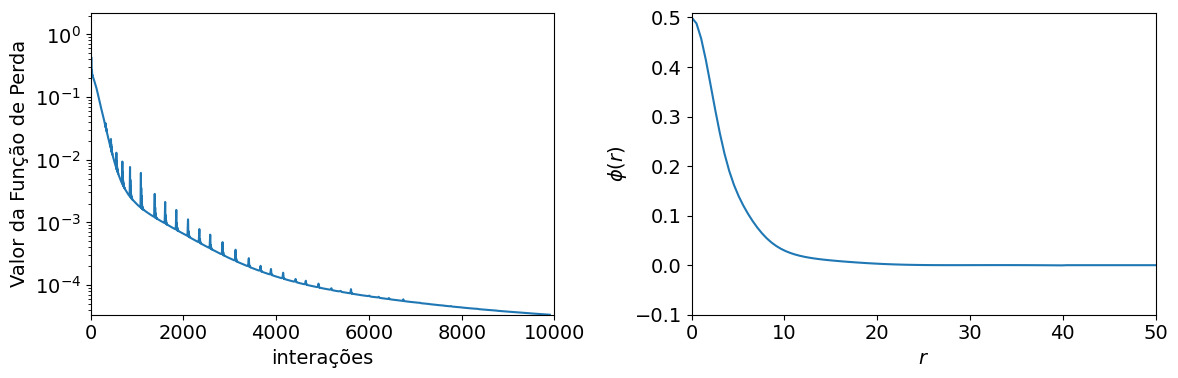

Final optimized omega: 0.9814005494117737 
 
 Error of omega: 0.0021396692421053803
Mean Absolute error of the PINN result: 0.0009421759


In [4]:
#Define different architecture for the model
class ODE(nn.Module):
    def __init__(self):
        super(ODE2, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 80),
            nn.GELU(),
            nn.Linear(80, 80),
           nn.GELU(),
           nn.Linear(80, 1),
        )


        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0.0)

#    def forward(self, r):
#        return self.net(r)


    def forward(self, r):
        # Compute the output of the neural network
        net_output = self.net(r)

        # Condition 1: Set phi(r) = phi0 when r is 0
        #condition1 = torch.isclose(r, torch.tensor(0.0), atol=1e-6)
        condition = (r > 40.0)

        # Apply the conditions using torch.where
        phi =  torch.where(condition, net_output * torch.exp(-10*r)*phi0, phi0*net_output)

        return phi



phi0 = 0.5


#potential derivative function
def dU_dPhi2(phi, m=1.0, beta=0.6, lambda_=0.1):
    return m**2 - 4 * beta * phi**2 + 6 * lambda_ * phi**4

#loss function
class ODELoss(nn.Module):
    def __init__(self, ode, omega, m=1.0, beta=0.6, lambda_=0.1, phi0 = phi0):
        super(ODELoss, self).__init__()
        self.ode = ode
        self.omega = omega
        self.m = m
        self.beta = beta
        self.lambda_ = lambda_
        self.phi0 = phi0

    def forward(self, r):
        phi = self.ode(r)
        dphi_dr = gradients(phi, r)
        d2phi_dr2 = gradients(dphi_dr, r)

        #Calculate the equation residual
        potential_term = dU_dPhi2(phi, self.m, self.beta, self.lambda_)
        eq_residual = d2phi_dr2 + (2/r) * dphi_dr - (potential_term - self.omega**2) * phi

        #Equation loss
        eq_loss = 20*torch.mean(eq_residual**2)

         #Boundary conditions
        num_boundary_points = 50 #Number of points near the boundary to enforce condition
        boundary_loss = torch.mean((phi[0] - phi0)**2) + torch.mean(phi[-num_boundary_points:]**2)

         # Non-negativity loss (penalizing negative values)
        non_negativity_loss = torch.mean(torch.relu(-phi)**2)

        #Eigenvalue adjustment loss
        phi_end = phi[-1]
        ad_intensity = lr
        adjust_omega_loss = ad_intensity*torch.sign(phi_end) * (self.omega - 1.0)**2

        return eq_loss + boundary_loss  + non_negativity_loss #+ adjust_omega_loss


ode = ODE()

# Initialize omega as a learnable parameter
omega = torch.tensor(1.2, requires_grad=True)  # Initial guess for omega

odeloss = ODELoss(ode, omega)
loss_hist = []
lr=1e-3
# Combine the parameters of the ODE and omega for optimization
optimizer = optim.Adam(list(ode.parameters()) + [omega], lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))


#Create input data
r = torch.tensor(np.linspace(0.01, 50, 100, dtype=np.float32)).reshape(100, 1)
r.requires_grad = True

#### Training the PINN ####

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
font = {'size': 19}
plt.rc('font', **font)


best_loss = float(1000)  #Initialize with infinity
best_model_state = None


omega_hist = []

for epoch in range(10000):
    try:
        optimizer.zero_grad()

        #first loss
        loss = odeloss(r)

        total_loss = loss

        #Backpropagate using the total loss
        total_loss.backward()
        optimizer.step()

        #Step the scheduler
        scheduler.step()

        #Store the total loss for monitoring
        loss_hist.append(total_loss.item())


        if epoch % 100 == 0:
            plt.rcParams['text.usetex'] = False
            plt.rcParams['font.size'] = 14

            ax1.cla()
            ax1.set_xlabel('interações')
            ax1.set_ylabel('Valor da Função de Perda')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.set_xlim([0, 10000])  # Set x-axis range for the epochs
            ax1.set_ylim([min(loss_hist), max(loss_hist)])  # Adjust y-axis range for the loss


            ax2.cla()
            ax2.set_xlabel(r'$r$')
            ax2.set_ylabel(r'$\phi(r)$')
            ax2.plot(r.cpu().detach().numpy(), ode(r).cpu().detach().numpy())
            ax2.set_xlim([0, 50])  # Set x-axis range for r
            ax2.set_ylim([-0.1, phi0+0.01])   # Set y-axis range for phi(r), adjust as needed


            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

            omega_hist.append(omega.item())

            # Print the current value of omega
            print(f'Epoch {epoch}, Current Omega: {omega.item()}')

    except KeyboardInterrupt:
        break

plt.show()

w, sol = solve_qb(phi0)


# Create a cubic spline interpolation function
f_cubic= CubicSpline(sol.t, sol.y[0])

x_new = np.linspace(0, 50, 100)

y_new_cubic = f_cubic(x_new)

mae_pinn = errfunc_mae(y_new_cubic,ode(r).cpu().detach().numpy())


# Final value of omega
print(f'Final optimized omega: {omega.item()}','\n','\n', 'Error of omega:', ((w-omega.item())/w))

print('Mean Absolute error of the PINN result:', mae_pinn)



- The model does present a good performance. But the loss functions defined above are more suitable for values of $\phi_{0}>0.2$. So the solutions considering $\phi_{0}<0.2$ will have higher MAE and poor convergence.

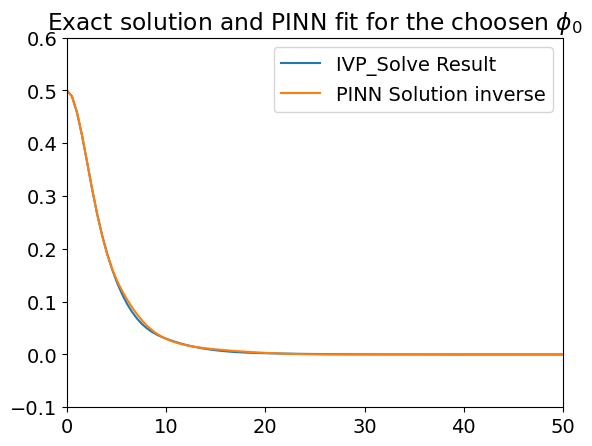

In [17]:
plt.plot(x_new,  y_new_cubic, label='IVP_Solve Result')
plt.plot(r.cpu().detach().numpy(),  ode(r).cpu().detach().numpy(), label='PINN Solution inverse')


plt.xlim([0, 50])
plt.ylim([-0.1, phi0+0.1])
plt.title(r'Exact solution and PINN fit for the choosen $\phi_{0}$')
plt.legend()
plt.show()

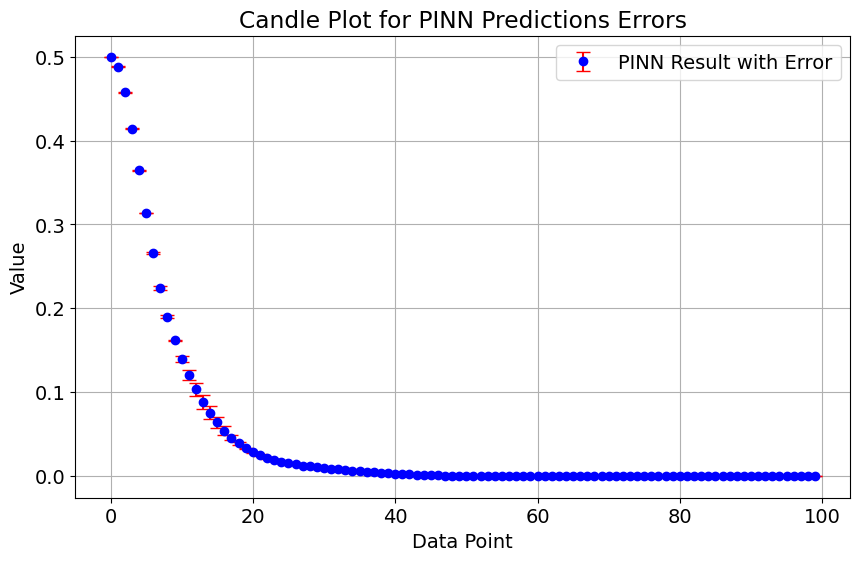

In [6]:
pinn_values = ode(r).cpu().detach().numpy().flatten()

error = np.abs(y_new_cubic - pinn_values)

# Plotting the candle plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(pinn_values)), pinn_values, yerr=error, fmt='o', capsize=5,
             label='PINN Result with Error', color='blue', ecolor='red')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Candle Plot for PINN Predictions Errors')
plt.grid(True)
plt.legend()
plt.show()

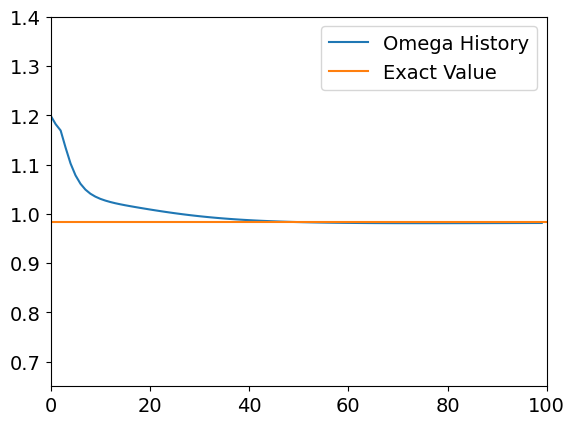

In [16]:
x=np.linspace(0,100,100)
y_w = np.full_like(x,w)

plt.plot( omega_hist, label='Omega History')
plt.plot(x, y_w, label='Exact Value')
plt.xlim([0, 100])
plt.ylim([0.65, 1.4])
plt.legend()
plt.show()

- As we can see above, the PINN search for the optmial $\omega$ values. To solve the Klein-Gordon equations, it is necessary to find the values of $\omega$ that fits de ODE and them is related to some solution. Such task is usually done by a shooting method. Using the PINNs, the algorithm simply search for the optimal value of $\omega$ by its own.  

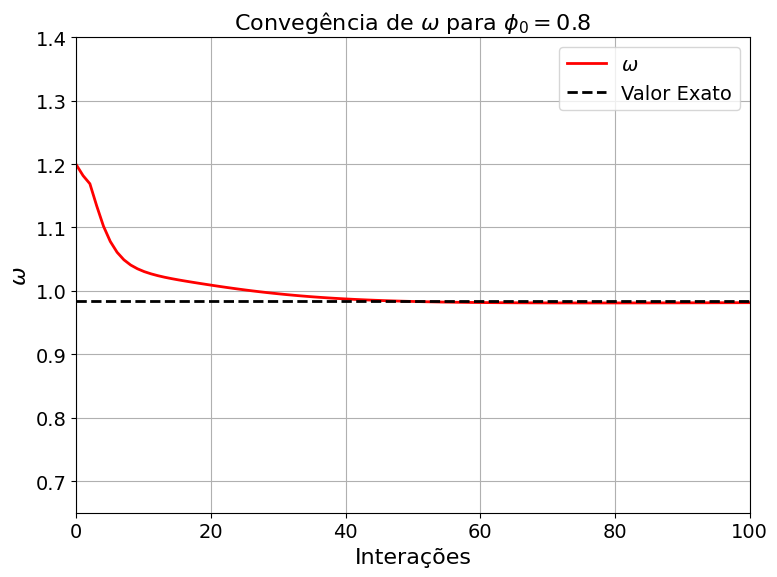

In [8]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

plt.figure(figsize=(8, 6))

plt.plot(x, omega_hist, 'r-', label=r'$\omega$', linewidth=2)

plt.plot(x, y_w, 'k--', label=r'Valor Exato', linewidth=2)

plt.xlim([0, 100])
plt.ylim([0.65, 1.4])

plt.xlabel(r'Interações', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)

plt.legend(fontsize=14)

plt.grid(True)
plt.title(r'Convegência de $\omega$ para $\phi_{0}=0.5$', fontsize=16)
plt.tight_layout()
plt.show()

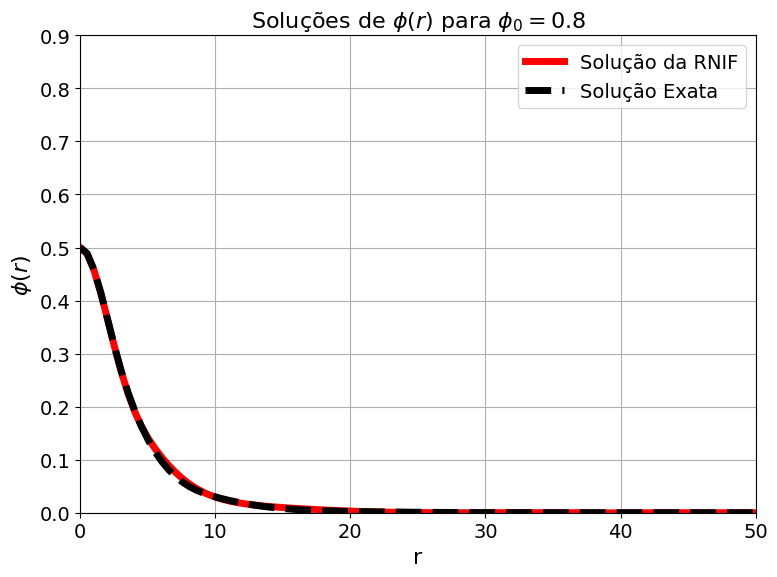

In [9]:

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

plt.figure(figsize=(8, 6))


plt.plot(x_new,  ode(r).cpu().detach().numpy(),'r-', label='Solução da RNIF',linewidth=5)

plt.plot(x_new,  y_new_cubic,'k--', label=r'Solução Exata',linewidth=5)



plt.xlim([0, 50])
plt.ylim([0, 0.9])

plt.xlabel(r'r', fontsize=16)
plt.ylabel(r'$\phi(r)$', fontsize=16)

plt.legend(fontsize=14)

plt.grid(True)
plt.title(r'Soluções de $\phi(r)$ para $\phi_{0}=0.5$', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

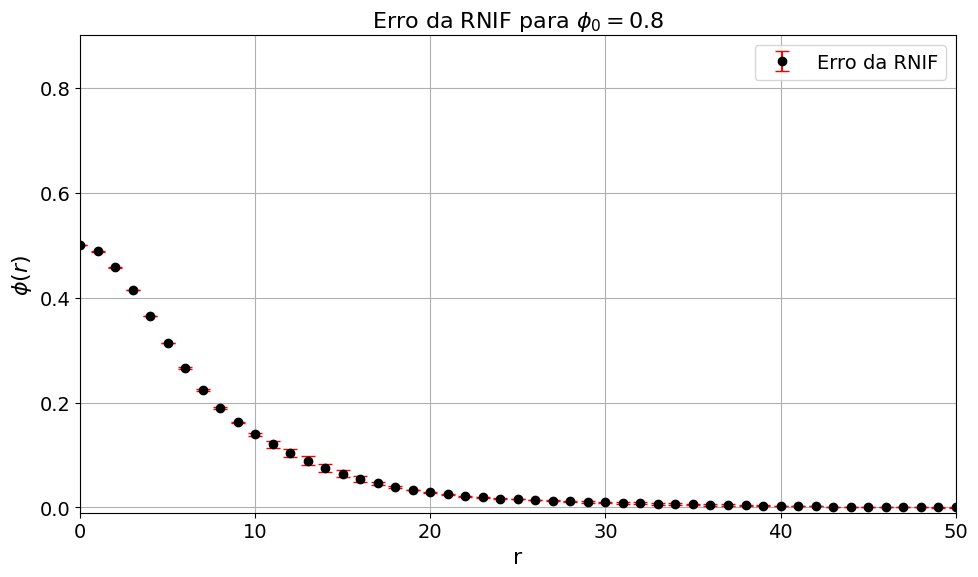

In [10]:

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

plt.figure(figsize=(8, 6))

plt.figure(figsize=(10, 6))
plt.errorbar(range(len(pinn_values)), pinn_values, yerr=error, fmt='o', capsize=5,
             label='Erro da RNIF', color='black', ecolor='red')


plt.xlim([0, 50])
plt.ylim([-0.01, 0.9])

plt.xlabel(r'r', fontsize=16)
plt.ylabel(r'$\phi(r)$', fontsize=16)

plt.legend(fontsize=14)

plt.grid(True)
plt.title(r'Erro da RNIF para $\phi_{0}=0.5$', fontsize=16)
plt.tight_layout()
plt.show()

### Save the PINN phi solution

In [11]:

pinndata_0_5 = np.column_stack((r.cpu().detach().numpy(), pinn_values))

# Save the data to a .dat file
np.savetxt('pinn_0_8_qb_exp.dat', pinndata_0_5, header='r phi', fmt='%.6f')

### Save the PINN LOSS history

In [12]:
epoch = np.arange(1, 10001, 1)

pinndata_0_5 = np.column_stack((epoch, loss_hist))

# Save the data to a .dat file
np.savetxt('loss_0_8_qb_exp.dat', pinndata_0_5, header='epoch loss', fmt='%.6f')

- This work is simply a toy model to show one applicability of PINNs implementation. In future versions some features may be improved. A good part of this project is based on the course: https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb

- Thank you for your attemption.
